# OpenContrails dataset documentation
 
The satellite images are originally obtained from the [GOES-16 Advanced Baseline Imager (ABI)](https://www.goes-r.gov/spacesegment/abi.html), which is publicly available on [Google Cloud Storage](https://console.cloud.google.com/storage/browser/gcp-public-data-goes-16/). The original full-disk images were reprojected using bilinear resampling to generate a local scene image. Because contrails are easier to identify with temporal context, a sequence of images at 10-minute intervals are provided. Each example contains exactly one labeled frame.

Learn more about the dataset from our preprint: [OpenContrails: Benchmarking Contrail Detection on GOES-16 ABI](https://arxiv.org/abs/2304.02122).

## Files
In each subdirectory named by `{record_id}`, binary files in numpy `.npy` format that corresponds to a single example are provided:

* **`band_{08-16}.npy`**: array with size of `H x W x T`, where `T = n_times_before + n_times_after + 1`, representing the number of images in the sequence. There are `n_times_before` and `n_times_after` images before and after the labeled frame respectively. In our dataset all examples have  `n_times_before=4` and `n_times_after=3`. Each band represents an infrared channel at different wavelengths and is converted to brightness temperatures based on the calibration parameters. The number in the filename corresponds to the GOES-16 ABI band number. Details of the ABI bands can be found [here](https://www.goes-r.gov/mission/ABI-bands-quick-info.html).
* **`human_individual_masks.npy`**: array with size of `H x W x 1 x R`. Each example is labeled by `R` individual human labelers. `R` is not the same for all samples. The labeled masks have value either 0 or 1 and correspond to the `(n_times_before+1)`-th image in `band_{08-16}.npy`. They are available only in the training set.
* **`human_pixel_masks.npy`**: array with size of `H x W x 1` containing the  binary groundtruth. A pixel is regarded as contrail pixel in evaluation if it is labeled as contrail by more than half of the labelers. 

**`{train/validation}_metadata.json`**: contains the timestamps and the projection parameters to reproduce the satellite images.


In [125]:
import os
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display

In [126]:
BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
N_TIMES_BEFORE = 4
id=1
# record_id = os.listdir(BASE_DIR)[id]
record_id = "1490059920504718587"

with open(os.path.join(BASE_DIR, record_id, 'band_11.npy'), 'rb') as f:
    band11 = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'band_14.npy'), 'rb') as f:
    band14 = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'band_15.npy'), 'rb') as f:
    band15 = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'human_pixel_masks.npy'), 'rb') as f:
    human_pixel_mask = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'human_individual_masks.npy'), 'rb') as f:
    human_individual_mask = np.load(f)

In [127]:
human_individual_mask.shape

(256, 256, 1, 7)

### Combine bands into a false color image
In order to view contrails in GOES, we use the "ash" color scheme. This color scheme was originally developed for viewing volcanic ash in the atmosphere but is also useful for viewing thin cirrus, including contrails. In this color scheme, contrails appear in the image as dark blue.

Note that we use a modified version of the ash color scheme here, developed by Kulik et al., which uses slightly different bands and bounds tuned for contrails.

References:
 - Ash Color Scheme (page 7): https://eumetrain.org/sites/default/files/2020-05/RGB_recipes.pdf

In [119]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band14, _T11_BOUNDS)
false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)

## Visualize data

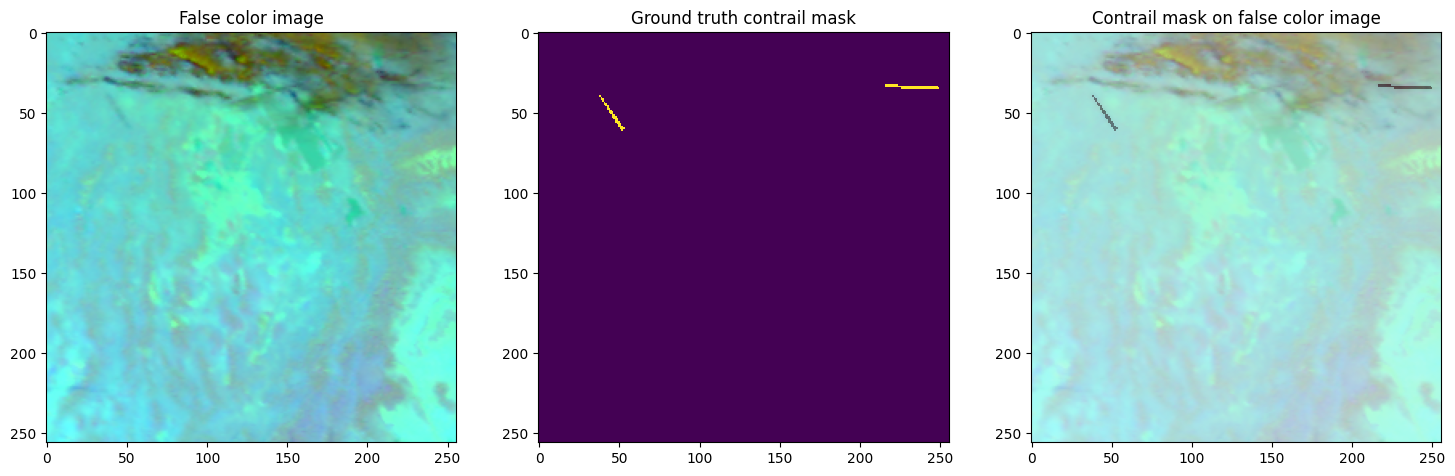

In [120]:
img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1, 3, 2)
ax.imshow(human_pixel_mask, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
ax.set_title('Contrail mask on false color image');

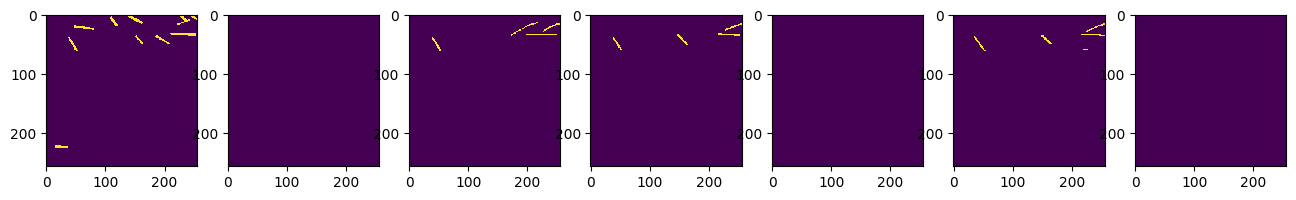

In [121]:
# Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_individual_mask[..., i], interpolation='none')

In [123]:
# Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
integrated_mask = np.zeros(human_individual_mask[..., 0].shape)
for i in range(n):
    integrated_mask += human_individual_mask[..., i]
integrated_mask = integrated_mask > n/2

print(np.array_equal(integrated_mask, human_pixel_mask))

True


<Figure size 1600x400 with 0 Axes>

In [54]:
for id in os.listdir(BASE_DIR):
    with open(os.path.join(BASE_DIR, id, 'human_individual_masks.npy'), 'rb') as f:
        human_individual_mask = np.load(f)
    n=human_individual_mask.shape[3]
    if n==7:
        print(id,n)

1015795485129760073 7
1037637192748343195 7
1045910853722873646 7
1153282134484095371 7
1168680127144148790 7
1201452000678266435 7
1202690141957954226 7
1219292725501510281 7
1241151518374933739 7
1282926554962068383 7
1327025405353646359 7
1433735035157082281 7
1459060753451279568 7
1465731703568832128 7
1474284721061533597 7
1477884912698510795 7
1490059920504718587 7
1511374651141384584 7
1511502238791901431 7
1538379551980087334 7
1569401126378072560 7
1571052375138371296 7
1582674860208357528 7
1617367839904160943 7
1682592779786685341 7
168852962316620781 7
1716126763922250087 7
1747499344522738142 7
1810624137729205182 7
181603602585723887 7


KeyboardInterrupt: 